In [1]:
!pip install tqdm

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)


In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import h5py
import os
import tqdm
import scipy
from scipy import signal
import pickle
from tqdm import tnrange
from tqdm import tqdm

import seaborn as sns
from scipy.stats import norm,entropy,linregress
from scipy.optimize import minimize, curve_fit
from scipy.io import savemat
#import multiprocess as mp
#from multiprocess import Pool
from scipy.special import erf
import sys
import warnings
#import odor_breathing_functions
#import functions_beh

warnings.filterwarnings('ignore')

cmap = plt.rcParams['axes.prop_cycle'].by_key()['color']
modulename = 'multiprocess'
mpl.rcParams['svg.fonttype'] = 'none'
sns.set_context('poster', font_scale=1.1)

path = os.getcwd() + '/Session/'
savepath = os.getcwd() + '/Figures/test/'
savepath_pdf = os.getcwd() + '/Figures/test/pdf/'
savepath_png = os.getcwd() + '/Figures/test/png/'
savepath_svg = os.getcwd() + '/Figures/test/svg/'

dir_list = os.listdir(path)
np_savepath = os.getcwd() + '/Other_outputs/MLE_arrays/'

print(os.getcwd())

/Users/boero/OEA_Data_Analysis


In [94]:
animal_list = [
               ['Banner'],
               ['Natasha'],
               ['Stark'],
               ['Peterparker']] #

# ['Tabby'],
#                ['Bengal'],
#                ['Shorthair'],

print(len(animal_list))

num_bins = 26
half_num_bins = 8
min_pulse = 1
max_pulse = 26
num_hist = 6
pulse_bins = np.linspace(min_pulse,max_pulse,max_pulse-min_pulse+1)

phigh_odor_list = list()
performance_odor_list = list()
bin_counts_odor_list = list()
# phigh_hist_list = list()
# performance_hist_list = list()
# bin_counts_hist_list = list()
phigh_catch_list = list()
performance_catch_list = list()
bin_counts_catch_list = list()

all_high_choices_list = list()
all_breathing_list =list()
all_cum_odor_list = list()
all_correct_trials_list = list()
all_catch_trials_list = list()

all_trial_odor_list = list()
all_catch_odor_list = list()
all_session_id_list = list()
all_trial_type_list = list()
all_ratios_list = list()
all_delay_times_list = list()


for animals in animal_list:
    fname_list = list()
    for date_number in range(20220101,20220412):
            
        for animal in animals:
            for session_id in range(0,10):
                session_string = str(session_id)
                date_string = str(date_number)
                fname = animal + '_' + date_string + '_' + session_string + '.pickle'

                cell_fname = path + 'session_' + fname
                if os.path.isfile(cell_fname):
                    fname_list.append(fname)

    all_trial_odor = np.zeros((0,5000))
    all_cum_odor = np.zeros((0,))
    all_catch_odor = np.zeros((0,5000))
    all_high_trials = np.zeros((0,))
    all_catch_trials = np.zeros((0,))
    all_high_choices = np.zeros((0,))
    all_correct_trials = np.zeros((0,))
    all_session_id =  np.zeros((0,))
    all_trial_type =  np.zeros((0,))
    all_ratios =  np.zeros((0,))
    all_delay_times =  np.zeros((0,))
    all_breathing = list()
    
    for i_file in tnrange(len(fname_list)): #, desc="Processing"
        fnamex = fname_list[i_file]
        session_fname = path + 'session_' + fnamex
        if os.path.isfile(session_fname):
            with open(session_fname,'rb') as handle:
                session_list = pickle.load(handle, encoding='latin1')
                if (session_list[0]['delay_time'] < 6) & (session_list[0]['delay_time'] % 1 == 0):
                    #if round(session_list[0]['high_count']/session_list[0]['low_count']) == 3:

                        date = fnamex[-17:-9]
                        print(date)

                        session = session_list[0]
                        num_trials = session['num_trials']                    
                        interval = int(session_list[0]['delay_time']*1000)

                        non_idle_trials = np.invert(session['idle_trials'])
                        #non_early_trials = np.invert(session['early_trials'])
                        valid_trials = non_idle_trials# & non_early_trials
                        correct_trials = session['correct_trials'][valid_trials]
                        #catch_trials = session['catch_trials'][valid_trials]
                        high_trials = session['high_trials'][valid_trials]
                        low_trials = session['low_trials'][valid_trials]
                        
                        delayt = np.repeat(interval, num_trials)[valid_trials]
                        sess_id = np.repeat(fnamex[:-7], num_trials)[valid_trials]
                        trial_type = np.repeat(session_list[0]['type'], num_trials)[valid_trials]
                        ratio = np.repeat(round(session_list[0]['high_count']/session_list[0]['low_count']), num_trials)[valid_trials]
                        high_choices = (correct_trials==high_trials)
                        # trial_odor = session['trial_odor'][valid_trials]
                        # trial_catch_odor = session['trial_catch_odor'][valid_trials]

                        breathing_signal = np.append(session['trial_pre_breath'][valid_trials, -5000:], 
                                                    session['trial_breath'][valid_trials, :interval], axis=1)
                        
                        # sniff_hist = get_sniff_histogram(session,False)[non_idle_trials]
                        # odor_onset = find_odor_onset_new(trial_odor)#.astype(np.float)
                        # coef_var  = get_blanks_duration(odor_onset)[1]
                        # sniff_hist_shuffled = get_sniff_histogram(session,True)[non_idle_trials]

                        # cum_odor = np.ceil(trial_odor.sum(axis=1)/(session['pulse_time_ms']*session['level1'])) 
                        # cum_catch_odor = np.ceil(trial_catch_odor.sum(axis=1)/(session['pulse_time_ms']*session['catch_level']))
                        # sum_odor = np.nansum([cum_odor, cum_catch_odor], axis=0)
                        #print(sum_odor)# + cum_catch_odor)
                        #print(high_trials)

                        all_session_id = np.append(all_session_id, sess_id)
                        all_trial_type = np.append(all_trial_type, trial_type)
                        all_ratios = np.append(all_ratios, ratio)
                        all_delay_times = np.append(all_delay_times, delayt)
                        # all_trial_odor = np.append(all_trial_odor, trial_odor[:,:interval], axis=0)
                        # all_catch_odor = np.append(all_catch_odor, trial_catch_odor[:,:interval], axis=0)
                        #all_breathing = np.append(all_breathing, breathing_signal[:,:11500], axis=0)

                        # all_trial_odor_onsets = np.append(all_trial_odor_onsets, odor_onset)
                        all_correct_trials = np.append(all_correct_trials,correct_trials)
                        all_high_trials = np.append(all_high_trials,high_trials)
                        #all_catch_trials = np.append(all_catch_trials, catch_trials)
                        all_high_choices = np.append(all_high_choices,high_choices)
                        # all_cum_odor = np.append(all_cum_odor,sum_odor)
                        # all_spectrogram = np.append(all_spectrogram[i_file,:,:], s_spect[:,:], axis=0)
                        # all_mean_dom_freq = np.append(all_mean_dom_freq, mean_dom_freq, axis=0)
                        # all_sem_dom_freq = np.append(all_sem_dom_freq, sem_dom_freq, axis=0)
                        # all_f = np.append(all_f, f, axis=0)
                        # all_t = np.append(all_t, t, axis=0)
                        # all_sniff_hist = np.append(all_sniff_hist,sniff_hist,axis=0)
                        # all_sniff_hist_shuffled = np.append(all_sniff_hist_shuffled,sniff_hist_shuffled,axis=0)
                        all_breathing.append((date, breathing_signal))

                # high_seven = all_cum_odor>8
                # low_eight = all_cum_odor<=8
                # #print(len(all_high_trials), len(all_session_id))
                # all_low_trials = np.invert(all_high_trials.astype(np.bool))
                # bad_trials_1 = np.logical_and(high_seven,all_low_trials)
                # bad_trials_2 = np.logical_and(low_eight,all_high_trials)
                # bad_trials = np.logical_or(bad_trials_1,bad_trials_2)
                # #print(len(catch_trials), catch_trials)
                # print('bad trials:', np.any(bad_trials))
                # #print(np.argwhere(bad_trials==True))
                # good_trials = np.invert(bad_trials)
                
                # all_correct_trials = all_correct_trials[good_trials]
                # all_high_trials = all_high_trials[good_trials]
                # all_low_trials = all_low_trials[good_trials]
                # all_high_choices = all_high_choices[good_trials]
                # all_catch_trials = all_catch_trials[good_trials]
                # all_cum_odor = all_cum_odor[good_trials]
                # all_catch_odor = all_catch_odor[good_trials,:]
                # all_trial_odor = all_trial_odor[good_trials,:]
                # all_session_id = all_session_id[good_trials]
                # all_trial_type = all_trial_type[good_trials]
                # all_ratios = all_ratios[good_trials]
                # all_delay_times = all_delay_times[good_trials]

                # all_sniff_hist = all_sniff_hist[good_trials,:]
                # all_sniff_hist_shuffled = all_sniff_hist_shuffled[good_trials,:]
                #all_spectrogram = all_spectrogram[good_trials,:]
                #all_mean_dom_freq = all_mean_dom_freq[good_trials]
                #all_sem_dom_freq = all_sem_dom_freq[good_trials]
                #all_f = np.append(f, axis=0)
                #all_t = np.append(t, axis=0)
        
    all_correct_trials_list.append(all_correct_trials)
    # all_coef_vars_list.append(all_coef_vars)
    all_high_choices_list.append(all_high_choices)
    all_catch_trials_list.append(all_catch_trials)
    # all_cum_odor_list.append(all_cum_odor)
    all_trial_type_list.append(all_trial_type)
    all_ratios_list.append(all_ratios)
    all_delay_times_list.append(all_delay_times)
    # all_sniff_hist_list.append(all_sniff_hist)
    # all_sniff_hist_shuffled_list.append(all_sniff_hist_shuffled)
    # all_trial_odor_list.append(all_trial_odor)
    # all_catch_odor_list.append(all_catch_odor)
    all_session_id_list.append(all_session_id)
    all_breathing_list.append(all_breathing)
    # all_spectrogram_list.append(all_spectrogram)
    # all_mean_dom_freq_list.append(all_mean_dom_freq)
    # all_sem_dom_freq_list.append(all_sem_dom_freq)
    # all_f_list.append(all_f)
    # all_t_list.append(all_t)

    

    # phigh_odor = np.zeros((num_bins,2))
    # performance_odor = np.zeros((num_bins,2))
    # # phigh_hist = np.zeros((num_bins,2))
    # # performance_hist = np.zeros((num_bins,2))
    # bin_counts_odor = np.zeros((num_bins,))
    # # bin_counts_h = np.zeros((num_bins,))
    # pulse_bin_ind = np.ceil(all_cum_odor).astype(int)

    # for i in range(num_bins):
    #     mask_odor = (all_catch_trials == 0) & (pulse_bin_ind==pulse_bins[i])
    #     selected_odor = all_high_choices[mask_odor]
    #     selected_correct_odor = all_correct_trials[mask_odor]
    #     num_selected_odor = len(selected_odor)
    #     # print(num_selected_odor)
    #     bin_counts_odor[i] = num_selected_odor
    #     phigh_odor[i,0] = selected_odor.mean()
    #     phigh_odor[i,1] = 1.96*selected_odor.std()/np.sqrt(num_selected_odor)
    #     performance_odor[i,0] = selected_correct_odor.mean()
    #     performance_odor[i,1] = 1.96*selected_correct_odor.std()/np.sqrt(num_selected_odor)
    # phigh_odor_list.append(phigh_odor)
    # performance_odor_list.append(performance_odor)
    # bin_counts_odor_list.append(bin_counts_odor)

    # phigh_catch = np.zeros((num_bins,2))
    # performance_catch = np.zeros((num_bins,2))
    # bin_counts_catch = np.zeros((num_bins,))

    # for i in range(num_bins):
    #     mask_catch = (all_catch_trials == 1) & (pulse_bin_ind==pulse_bins[i])
    #     selected_catch = all_high_choices[mask_catch]
    #     selected_correct_catch = all_correct_trials[mask_catch]
    #     num_selected_catch = len(selected_catch)
    #     # print(num_selected_catch)
    #     bin_counts_catch[i] = num_selected_catch
    #     phigh_catch[i,0] = selected_odor.mean()
    #     phigh_catch[i,1] = 1.96*selected_catch.std()/np.sqrt(num_selected_catch)
    #     performance_odor[i,0] = selected_correct_catch.mean()
    #     performance_odor[i,1] = 1.96*selected_correct_catch.std()/np.sqrt(num_selected_catch)
    # phigh_catch_list.append(phigh_catch)
    # performance_catch_list.append(performance_catch)
    # bin_counts_catch_list.append(bin_counts_catch)



4


  0%|          | 0/116 [00:00<?, ?it/s]

20220128
20220201
20220202
20220203
20220204
20220205
20220206
20220206
20220207
20220207
20220208
20220208
20220209
20220209
20220211
20220211
20220212
20220212
20220213
20220213
20220213
20220214
20220214
20220214
20220215
20220215
20220216
20220216
20220216
20220217
20220217
20220218
20220218
20220219
20220221
20220221
20220221
20220222
20220222
20220222
20220222
20220223
20220223
20220223
20220223
20220224
20220224
20220224
20220224
20220224
20220225
20220225
20220225
20220225
20220225
20220227
20220227
20220227
20220228
20220228
20220228
20220228
20220301
20220301
20220301
20220301
20220302
20220302
20220302
20220302
20220303
20220303
20220303
20220303
20220304
20220304
20220304
20220305
20220305
20220305
20220313
20220313
20220314
20220315
20220317
20220317
20220318
20220318
20220319
20220319
20220321
20220321
20220322
20220322
20220323
20220323
20220324
20220325
20220326
20220328
20220328
20220330
20220331
20220331


  0%|          | 0/102 [00:00<?, ?it/s]

20220128
20220128
20220128
20220201
20220202
20220202
20220203
20220204
20220205
20220205
20220206
20220206
20220207
20220207
20220208
20220208
20220209
20220209
20220211
20220211
20220212
20220213
20220213
20220213
20220214
20220215
20220215
20220216
20220216
20220216
20220217
20220217
20220218
20220218
20220218
20220218
20220219
20220221
20220221
20220221
20220222
20220222
20220222
20220222
20220223
20220223
20220223
20220223
20220224
20220224
20220224
20220224
20220225
20220225
20220225
20220227
20220227
20220228
20220228
20220228
20220228
20220301
20220301
20220302
20220302
20220302
20220302
20220303
20220303
20220304
20220304
20220305
20220305
20220313
20220313
20220314
20220315
20220317
20220317
20220317
20220317
20220318
20220318
20220319
20220321
20220322
20220323
20220324
20220325
20220326
20220328
20220330
20220331


  0%|          | 0/105 [00:00<?, ?it/s]

20220128
20220128
20220201
20220202
20220202
20220203
20220204
20220205
20220205
20220206
20220207
20220207
20220208
20220208
20220209
20220209
20220211
20220211
20220212
20220212
20220213
20220213
20220213
20220214
20220214
20220215
20220215
20220216
20220216
20220216
20220217
20220217
20220218
20220218
20220218
20220218
20220219
20220221
20220221
20220222
20220222
20220222
20220222
20220223
20220223
20220223
20220224
20220224
20220224
20220224
20220225
20220225
20220225
20220225
20220227
20220227
20220228
20220228
20220228
20220228
20220301
20220301
20220302
20220302
20220302
20220302
20220302
20220303
20220303
20220304
20220305
20220305
20220313
20220314
20220315
20220315
20220317
20220317
20220318
20220318
20220319
20220321
20220322
20220322
20220323
20220323
20220324
20220324
20220325
20220325
20220326
20220326
20220328
20220330
20220331


  0%|          | 0/108 [00:00<?, ?it/s]

20220128
20220128
20220201
20220202
20220202
20220203
20220204
20220204
20220205
20220205
20220205
20220205
20220206
20220207
20220207
20220207
20220207
20220208
20220209
20220209
20220211
20220211
20220212
20220213
20220213
20220214
20220214
20220215
20220215
20220216
20220217
20220217
20220218
20220218
20220218
20220218
20220218
20220218
20220219
20220221
20220221
20220222
20220222
20220222
20220223
20220223
20220223
20220223
20220223
20220224
20220224
20220224
20220224
20220225
20220225
20220227
20220227
20220227
20220228
20220228
20220228
20220228
20220301
20220301
20220302
20220302
20220302
20220302
20220303
20220303
20220304
20220304
20220305
20220305
20220313
20220313
20220313
20220314
20220314
20220314
20220315
20220317
20220317
20220317
20220318
20220318
20220319
20220319
20220321
20220322
20220323
20220323
20220324
20220324
20220325
20220326
20220328
20220330
20220331
20220401
20220404
20220404
20220405
20220406
20220407
20220408
20220410
20220411


In [161]:
print(len(all_breathing_list[1]))

63


In [165]:
print(len(all_breathing_list[1][61][1]), all_breathing_list[1][62][0])

225 20250818


In [ ]:
results_list=list()

for i in range(len(all_correct_trials_list)):
    for j in range(len(all_correct_trials_list[i])):
        result_row_1 = {'Animal': i,
                'Session': all_session_id_list[i][j],
                'Total_pulse': all_cum_odor_list[i][j].astype(int),
                'Correct': all_correct_trials_list[i][j].astype(int),
                'High_choice': all_high_choices_list[i][j].astype(int),
                'Catch_trial': all_catch_trials_list[i][j].astype(int)}
                #'Trial odor': all_trial_odor_list[i][j].flatten().tolist(),
                #'Odor onsets': all_trials_odor_onsets_list[i][j],
                #'Sniff_histogram': all_sniff_hist_list[i][j].astype(int)}
                #'Breathing': all_breathing_list[i][j].flatten().tolist(),
                #'CV': all_coef_vars_list[i][j]}
        results_list.append(result_row_1)
df_test = pd.DataFrame(results_list)
df_test

0
0
0
1
0
2
0
3
0
4
0
5
0
6
0
7
0
8
0
9
0
10
0
11
0
12
0
13
0
14
0
15
0
16
0
17
0
18
0
19
0
20
0
21
0
22
0
23
0
24
0
25
0
26
0
27
0
28
0
29
0
30
0
31
0
32
0
33
0
34
0
35
0
36
0
37
0
38
0
39
0
40
0
41
0
42
0
43
0
44
0
45
0
46
0
47
0
48
0
49
0
50
0
51
0
52
0
53
0
54
0
55
0
56
0
57
0
58
0
59
0
60
0
61
0
62
0
63
0
64
0
65
0
66
0
67
0
68
0
69
0
70
0
71
0
72
0
73
0
74
0
75
0
76
0
77
0
78
0
79
0
80
0
81
0
82
0
83
0
84
0
85
0
86
0
87
0
88
0
89
0
90
0
91
0
92
0
93
0
94
0
95
0
96
0
97
0
98
0
99
0
100
0
101
0
102
0
103
0
104
0
105
0
106
0
107
0
108
0
109
0
110
0
111
0
112
0
113
0
114
0
115
0
116
0
117
0
118
0
119
0
120
0
121
0
122
0
123
0
124
0
125
0
126
0
127
0
128
0
129
0
130
0
131
0
132
0
133
0
134
0
135
0
136
0
137
0
138
0
139
0
140
0
141
0
142
0
143
0
144
0
145
0
146
0
147
0
148
0
149
0
150
0
151
0
152
0
153
0
154
0
155
0
156
0
157
0
158
0
159
0
160
0
161
0
162
0
163
0
164
0
165
0
166
0
167
0
168
0
169
0
170
0
171
0
172
0
173
0
174
0
175
0
176
0
177
0
178
0
179
0
180
0
181
0
182
0
183
0
184


In [33]:
ncolors = 7

### Establishing color palettes
cmap = plt.get_cmap("tab10")
cmap_2 = sns.color_palette("rocket", 7)
cmap_3 = sns.color_palette("mako", 7)
cmap_4 = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)(np.linspace(0, 0.75, ncolors))
#cmap_5 = sns.color_palette("rocket_r", as_cmap=True)
cmap_5 = sns.color_palette("rocket_r", as_cmap=True)(np.linspace(0.1, 0.8, ncolors))

cmap_6 = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)(np.linspace(0, 0.8, 5))
cmap_7 = sns.color_palette("YlGn", 10)
cmap_8 = sns.color_palette("bone_r", 10)
cmap_9 = sns.color_palette("Accent", 12)
cmap_10 = sns.color_palette('bright',10)
cmap_11 = sns.color_palette('plasma',10)

greys = sns.color_palette("Greys", 10)
colors = plt.cm.get_cmap('BuGn')(np.linspace(0.4, 1, ncolors))
colors = plt.cm.get_cmap('BuGn')(np.linspace(0.4, 1, ncolors))
c_2 = plt.cm.get_cmap('RdPu')
blue_palette = sns.dark_palette(cmap(0),n_colors=9, reverse=True)
orange_palette = sns.dark_palette(cmap(1),n_colors=9, reverse=True)
red_palette = sns.dark_palette(cmap(3),n_colors=9, reverse=True)

catch_palette = {0: cmap_5[5], 1: greys[5]}

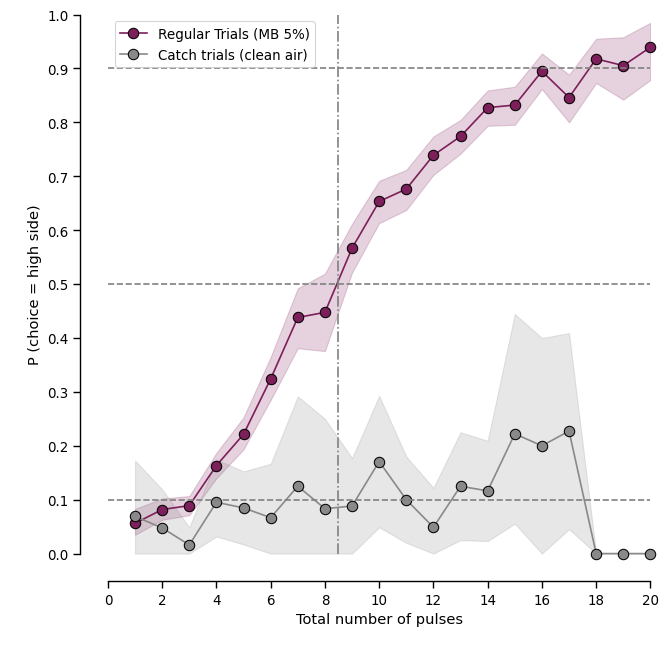

In [109]:
fig = plt.figure(figsize=(7,7))

sns.set_context('paper', font_scale=1.1)

ax = sns.lineplot(df_test.loc[df_test['Total_pulse']<21], x='Total_pulse', y='High_choice', hue ='Catch_trial', 
                  clip_on=False, err_style="band", marker='.', markersize=15, palette=catch_palette, markeredgecolor='black', legend=True)
              #markers="o", markersize=8)

plt.xticks(np.linspace(0,20,11))
plt.yticks(np.linspace(0,1,11))

plt.xlabel('Total number of pulses')
plt.ylabel('P (choice = high side)')


plt.axhline(y=0.1,color='gray',linestyle='--')
plt.axhline(y=0.5,color='gray',linestyle='--')
plt.axhline(y=0.9,color='gray',linestyle='--')
plt.axvline(x=8.5,color='gray',linestyle='-.')

plt.ylim(0,1)
plt.xlim(0,20)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ["Regular Trials (MB 5%)", "Catch trials (clean air)"], loc="upper left")
sns.despine(right=True, top=True, offset=20)


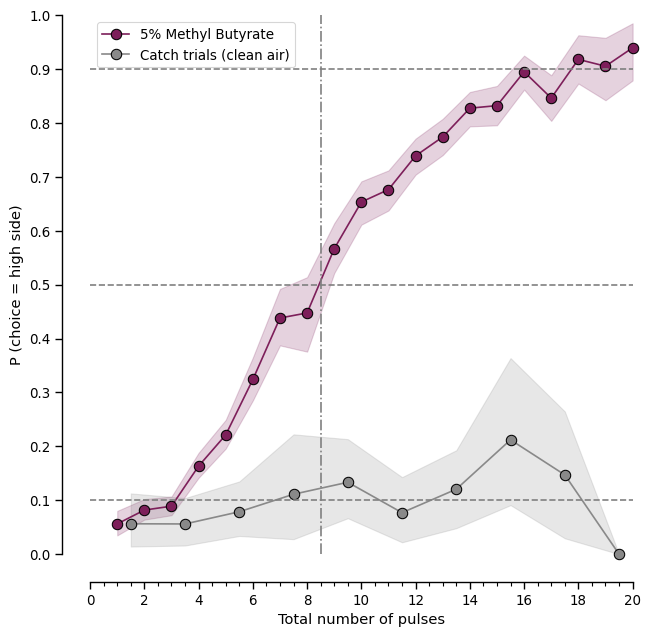

In [122]:
from matplotlib.ticker import MultipleLocator
fig = plt.figure(figsize=(7,7))

sns.lineplot(
    data=df_test.loc[(df_test['Total_pulse']<21) & (df_test['Catch_trial']==0)],
    x="Total_pulse",
    y="High_choice",
    estimator="mean",
    errorbar=("ci", 95),   # bootstrapped 95% CI
    marker='.', color = cmap_5[5], markeredgecolor='black', markersize=15,
    clip_on=False,
    label="5% Methyl Butyrate")

restricted_df = df_test.loc[(df_test['Total_pulse']<21) & df_test['Catch_trial']==1]
bins = np.arange(0, 22, 2)   # 0,2,4,...,20
labels = bins[:-1] + 1.5  # midpoint of each bin (e.g. 1.5, 3.5, ...)
restricted_df["pulse_bin"] = pd.cut(restricted_df["Total_pulse"], bins=bins, labels=labels, include_lowest=True)
restricted_df["pulse_mid"] = restricted_df["pulse_bin"].astype(float)

sns.lineplot(
    data=restricted_df,
    x="pulse_mid",
    y="High_choice",
    estimator="mean",
    errorbar=("ci", 95),   # bootstrapped 95% CI
    marker='.', color = greys[5], markeredgecolor='black', markersize=15,
    clip_on=False,
    label="Catch trials (clean air)")

plt.xticks(np.linspace(0,20,11))
plt.yticks(np.linspace(0,1,11))
plt.xlabel('Total number of pulses')
plt.ylabel('P (choice = high side)')

plt.gca().xaxis.set_major_locator(MultipleLocator(2))   # major ticks at 1
plt.gca().xaxis.set_minor_locator(MultipleLocator(0.5)) # subticks at 0.5

plt.axhline(y=0.1,color='gray',linestyle='--')
plt.axhline(y=0.5,color='gray',linestyle='--')
plt.axhline(y=0.9,color='gray',linestyle='--')
plt.axvline(x=8.5,color='gray',linestyle='-.')

plt.ylim(0,1)
plt.xlim(0,20)
plt.legend()
sns.despine(right=True, top=True, offset=20)

fig.savefig('psychometric_mb_vs_catch.svg',transparent = True, format='svg', bbox_inches='tight')
fig.savefig('psychometric_mb_vs_catch.png',transparent = True, format='png', bbox_inches='tight')
fig.savefig('psychometric_mb_vs_catch.pdf',transparent = True, format='pdf', bbox_inches='tight')

plt.show()


In [35]:
#Pooling data for posterior analysis

pool_correct_trials_odor = np.zeros((0,))
pool_high_choices_odor = np.zeros((0,))
pool_cum_odor_odor = np.zeros((0,))
for i in range(len(all_correct_trials_list)):
    pool_correct_trials_odor = np.append(pool_correct_trials_odor,all_correct_trials_list[i][all_catch_trials_list[i] == 0])
    pool_high_choices_odor = np.append(pool_high_choices_odor,all_high_choices_list[i][all_catch_trials_list[i] == 0])
    pool_cum_odor_odor = np.append(pool_cum_odor_odor,all_cum_odor_list[i][all_catch_trials_list[i] == 0])

phigh_pooled_odor = np.zeros((num_bins,2))
performance_pooled_odor = np.zeros((num_bins,2))
bin_counts_pooled_odor = np.zeros((num_bins,))
pulse_bin_ind = np.ceil(pool_cum_odor_odor).astype(int)

for i in range(num_bins):
    selected = pool_high_choices_odor[pulse_bin_ind==pulse_bins[i]]
    selected_correct = pool_correct_trials_odor[pulse_bin_ind==pulse_bins[i]]
    num_selected = len(selected)
    bin_counts_pooled_odor[i] = num_selected
    phigh_pooled_odor[i,0] = selected.mean()
    phigh_pooled_odor[i,1] = 1.96*selected.std()/np.sqrt(num_selected)
    performance_pooled_odor[i,0] = selected_correct.mean()
    performance_pooled_odor[i,1] = 1.96*selected_correct.std()/np.sqrt(num_selected)

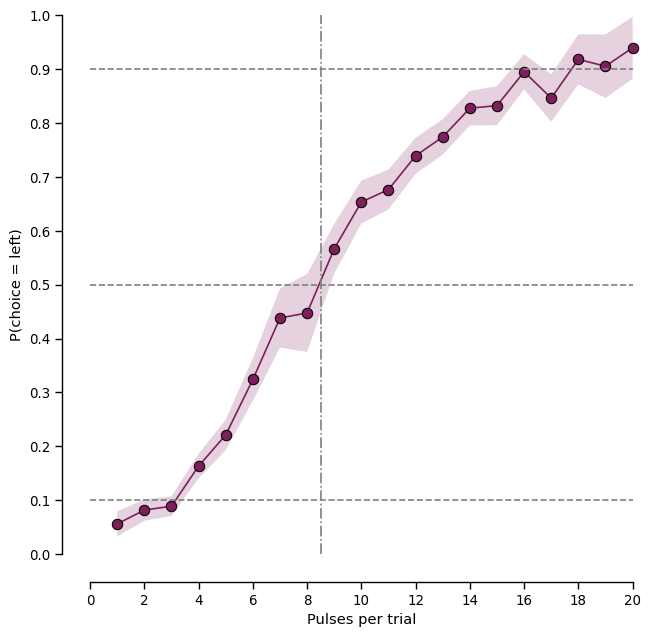

In [113]:
fig = plt.figure(figsize=(7,7))

ax = sns.lineplot(x=pulse_bins[0:20],y=phigh_pooled_odor[0:20,0],color=cmap_5[5],  
                  marker='.',markeredgecolor='k', markersize=15, clip_on=False)
ax.fill_between(pulse_bins[0:20], phigh_pooled_odor[0:20,0] - phigh_pooled_odor[0:20,1], phigh_pooled_odor[0:20,0] + phigh_pooled_odor[0:20,1], 
                   alpha=0.2, color=cmap_5[5], edgecolor=None)

plt.xlabel('Pulses per trial')  #'$N_{pulses}$'
plt.axhline(y=0.1,color='gray',linestyle='--')
plt.axhline(y=0.5,color='gray',linestyle='--')
plt.axhline(y=0.9,color='gray',linestyle='--')
plt.axvline(x=8.5,color='gray',linestyle='-.')
plt.ylim(0,1)
plt.xlim(0,20)
plt.yticks(np.linspace(0,1,11))
plt.ylabel('P(choice = left)')  #$P$(choice = left)
plt.xticks(np.linspace(0,20,11))
sns.despine(right=True, top=True, offset=20)

In [151]:
print(len(all_spectrogram_list[0]))

28


ValueError: not enough values to unpack (expected 2, got 0)

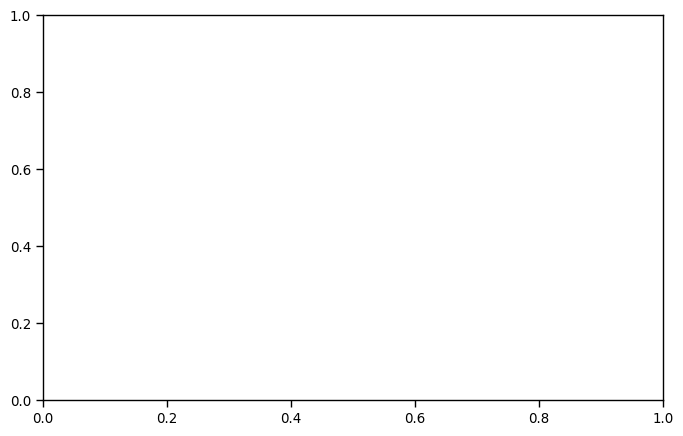

In [130]:
fs = 1000
spec_list = []
for i in range(len(all_breathing_list)):
    all_b = all_breathing_list[i]
    for j in range(len(all_b)):
        f, t, Sxx = signal.spectrogram(all_b[j,:], fs, nperseg=fs*2, noverlap=fs)
        print(type(Sxx), Sxx.shape)
        spec_list.append(Sxx)

Sxx_mean = np.mean(spec_list, axis=0)  # average across trials

plt.figure(figsize=(8,5))
plt.pcolormesh(t, f, 10*np.log10(Sxx_mean), shading='gouraud')
plt.ylim(0, 15)
plt.colorbar(label='Power (dB)')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.title('Average Breathing Spectrogram Across Trials')
plt.show()

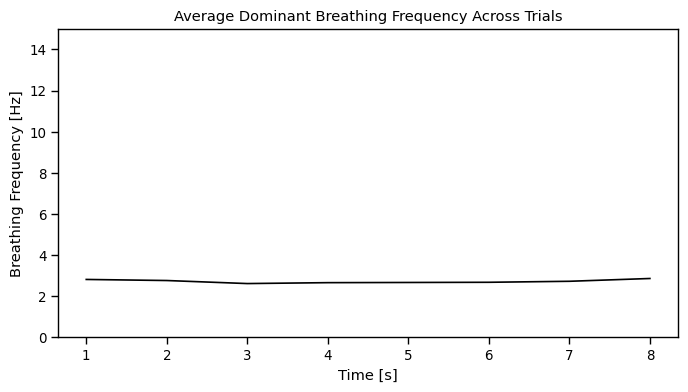

In [118]:
dominant_freq_trials = []
for i in range(len(all_breathing_list)):
    all_b = all_breathing_list[i]
    for j in range(len(all_b)):
        f, t, Sxx = signal.spectrogram(all_b[j,:], fs, nperseg=fs*2, noverlap=fs)
        dominant_freq_trials.append(f[np.argmax(Sxx, axis=0)])

dominant_freq_trials = np.array(dominant_freq_trials)  # shape (n_trials, len(t))

# Average and SEM across trials
mean_freq = np.nanmean(dominant_freq_trials, axis=0)
sem_freq = np.nanstd(dominant_freq_trials, axis=0) / np.sqrt(dominant_freq_trials.shape[0])

plt.figure(figsize=(8,4))
plt.plot(t, mean_freq, color='k')
plt.fill_between(t, mean_freq-sem_freq, mean_freq+sem_freq, alpha=0.3)
plt.ylim(0, 15)
plt.xlabel('Time [s]')
plt.ylabel('Breathing Frequency [Hz]')
plt.title('Average Dominant Breathing Frequency Across Trials')
plt.show()

(0.0, 14.0)

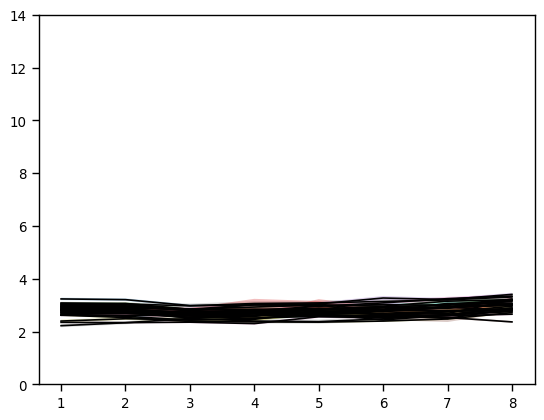

In [158]:
for i in range(len(all_mean_dom_freq)):
    mean_freq = all_mean_dom_freq[i,:]
    sem_freq = all_sem_dom_freq[i,:]
    plt.plot(t, mean_freq, color='k')
    plt.fill_between(t, mean_freq-sem_freq, mean_freq+sem_freq, alpha=0.3)

plt.ylim(0,14)

(0.0, 14.0)

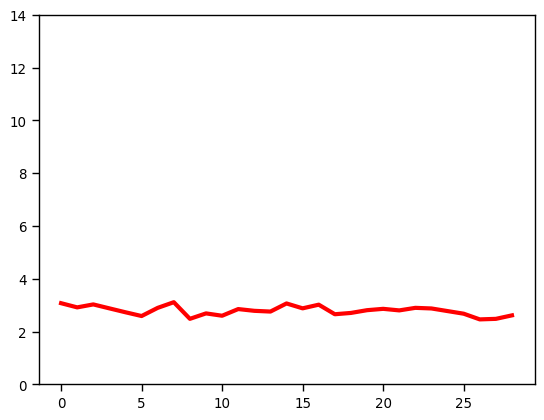

In [160]:
plt.plot(range(all_mean_dom_freq.shape[0]), np.mean(all_mean_dom_freq, axis=1), color='r', linewidth=3)
plt.ylim(0,14)

In [6]:
from collections import defaultdict
from scipy.signal import spectrogram
import numpy as np

spec_list = []
dominant_freq_list = []
time_varying_dom_list = []

for i in range(len(all_breathing_list)):
    all_breathing = all_breathing_list[i]

    # Group trials by date
    trials_by_date = defaultdict(list)
    for date, breathing_signal in all_breathing:
        if breathing_signal.ndim == 1:
            trials_by_date[date].append(breathing_signal[np.newaxis, :])  # convert to 2D
        else:
            trials_by_date[date].append(breathing_signal)  # already 2D

    spectrograms = []
    dominant_freq = []
    time_varying_dom = []

    # Compute spectrogram per date
    for date, trial_list in trials_by_date.items():
        # Concatenate all trials for this date
        all_trials = np.vstack(trial_list)  # shape: (n_trials, n_samples)

        # Compute spectrogram per trial and average
        Sxx_trials = []
        for trial in all_trials:
            f, t, Sxx = spectrogram(trial, fs=fs, nperseg=2048, noverlap=1024)
            Sxx_trials.append(Sxx)
        Sxx_mean = np.mean(Sxx_trials, axis=0)

        # Save full spectrogram
        spectrograms.append((date, f, t, Sxx_mean))

        # Compute global dominant frequency
        mean_power = np.mean(Sxx_mean, axis=1)
        dom_freq_val = f[np.argmax(mean_power)]
        dominant_freq.append([date, dom_freq_val])

        # Time-varying dominant frequency
        dom_freq_time = f[np.argmax(Sxx_mean, axis=0)]
        time_varying_dom.append((date, dom_freq_time))

    # Save results per subject
    spec_list.append(spectrograms)
    dominant_freq_list.append(np.array(dominant_freq))
    time_varying_dom_list.append(time_varying_dom)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 3000 and the array at index 1 has size 4000

0 [['20250723' '2.44140625']
 ['20250724' '2.9296875']
 ['20250725' '1.953125']
 ['20250727' '2.9296875']
 ['20250728' '2.9296875']
 ['20250729' '2.9296875']
 ['20250730' '2.44140625']
 ['20250731' '2.9296875']
 ['20250801' '2.44140625']
 ['20250804' '2.9296875']
 ['20250805' '2.9296875']
 ['20250807' '2.44140625']
 ['20250808' '2.9296875']
 ['20250813' '2.44140625']
 ['20250814' '2.44140625']
 ['20250815' '2.44140625']
 ['20250816' '2.44140625']
 ['20250818' '2.44140625']]
<built-in function sorted>
1 [['20250723' '2.9296875']
 ['20250724' '2.9296875']
 ['20250725' '2.9296875']
 ['20250727' '2.9296875']
 ['20250729' '2.44140625']
 ['20250730' '2.44140625']
 ['20250731' '2.44140625']
 ['20250801' '2.44140625']
 ['20250804' '2.44140625']
 ['20250805' '2.44140625']
 ['20250807' '2.44140625']
 ['20250808' '1.953125']
 ['20250813' '2.44140625']
 ['20250816' '1.953125']
 ['20250818' '1.953125']]
<built-in function sorted>
2 [['20250722' '2.9296875']
 ['20250723' '2.9296875']
 ['20250724' '2

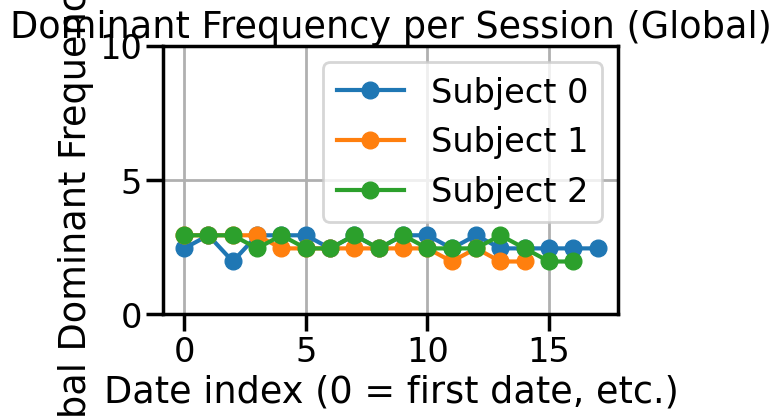

In [270]:
import numpy as np
import matplotlib.pyplot as plt

for subj_idx, subj_dom in enumerate(dominant_freq_list):
    print(subj_idx, subj_dom)
    # subj_dom[:,0] is the date (or date index)
    sorted_idx = np.argsort(subj_dom[:,0].astype(int))  # sort numerically by date
    print(sorted)
    x_vals = np.arange(len(subj_dom))  # 0,1,2,...
    y_vals = subj_dom[sorted_idx, 1].astype(float)  # dominant frequency values sorted by date
    #print(type(y_vals[0]))  # dominant frequency

    plt.plot(x_vals, y_vals, 'o-', label=f"Subject {subj_idx}")

plt.xlabel("Date index (0 = first date, etc.)")
plt.ylabel("Global Dominant Frequency (Hz)")
plt.title("Dominant Frequency per Session (Global)")
plt.ylim(0, 10)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [129]:
print(all_breathing_list[0][0][0:5])

('20250818', array([[1.91131746, 1.92614253, 1.93516648, ..., 1.54971512, 1.55261567,
        1.56131733],
       [0.35984639, 0.26928502, 0.19161495, ..., 2.844009  , 2.77729597,
        2.69253499],
       [1.94838012, 1.94773555, 1.93806703, ..., 2.38604216, 2.36799423,
        2.35929254],
       ...,
       [0.06366886, 0.06270201, 0.06302429, ..., 3.60943798, 3.62684145,
        3.63747691],
       [1.51265251, 1.50137259, 1.49073724, ..., 0.06560255, 0.06689168,
        0.06044603],
       [1.76790115, 1.77982565, 1.80335236, ..., 2.74474517, 2.74313375,
        2.74700117]]))


In [29]:
def group_and_pad_by_date(subject_breathing_list):
    """
    Combine breathing trials by date, padding to each date's max trial length.

    Parameters
    ----------
    subject_breathing_list : list of (date, breathing_array) tuples
        Each breathing_array is 2D (trials x time).

    Returns
    -------
    grouped : dict
        Keys = dates, values = arrays (trials x max_len_for_that_date)
    """
    grouped = {}

    # Group by date
    for date, arr in subject_breathing_list:
        if date not in grouped:
            grouped[date] = []
        grouped[date].append(arr)

    # Pad per date
    padded_grouped = {}
    for date, arrays in grouped.items():
        # print(date, len(arrays))
        max_len = max(a.shape[1] for a in arrays)  # max trial length for this date
        padded_arrays = []
        for a in arrays:
            pad_width = max_len - a.shape[1]
            if pad_width > 0:
                a_padded = np.pad(a, ((0,0), (0,pad_width)), mode="constant")
            else:
                a_padded = a
            padded_arrays.append(a_padded)
        padded_grouped[date] = np.concatenate(padded_arrays, axis=0)

    return padded_grouped

#print(all_breathing_list[2][1][1].shape)  # first subject's breathing data

subject0_grouped = group_and_pad_by_date(all_breathing_list[0])

for date, arr in subject0_grouped.items():
    print(date, arr.shape)  # each date has its own trial length

20220305 (197, 10000)
20220313 (160, 10000)
20220314 (128, 10000)
20220315 (168, 10000)
20220317 (170, 10000)
20220318 (235, 10000)
20220319 (180, 10000)
20220321 (227, 10000)
20220322 (253, 10000)
20220323 (246, 10000)
20220324 (258, 10000)
20220325 (183, 10000)
20220326 (231, 10000)


In [111]:
spec_list = []
dominant_freq_list = []
time_varying_dom_list = []

for i in range(len(all_breathing_list)):
    # --- Group and pad trials per date for this subject ---
    grouped_by_date = group_and_pad_by_date(all_breathing_list[i])

    spectrograms = []
    dominant_freq = []
    time_varying_dom = []

    # --- Compute spectrogram per date ---
    for date, all_trials in grouped_by_date.items():  
        # all_trials shape: (n_trials, max_len_for_this_date)

        Sxx_trials = []
        for trial in all_trials:
            f, t, Sxx = spectrogram(trial, fs=1000, nperseg=2000, noverlap=1000)
            Sxx_trials.append(Sxx)

        # Average across trials
        Sxx_mean = np.mean(Sxx_trials, axis=0)

        # Save full spectrogram
        spectrograms.append((date, f, t, Sxx_mean))

        # --- Global dominant frequency (across all time bins) ---
        mean_power = np.mean(Sxx_mean, axis=1)
        dom_freq_val = f[np.argmax(mean_power)]
        dominant_freq.append([date, dom_freq_val])

        # --- Time-varying dominant frequency (per time bin) ---
        dom_freq_time = f[np.argmax(Sxx_mean, axis=0)]
        time_varying_dom.append((date, dom_freq_time))

    # Save results per subject
    spec_list.append(spectrograms)
    dominant_freq_list.append(np.array(dominant_freq))
    time_varying_dom_list.append(time_varying_dom)

In [112]:
print(len(dominant_freq_list))
loaded0 = np.load("dom_freq_0.npy")
loaded1 = np.load("dom_freq_1.npy")
loaded2 = np.load("dom_freq_2.npy")

# list0 = loaded0.tolist()
# list1 = loaded1.tolist()
# list2 = loaded2.tolist()

dominant_freq_list.append(loaded0)
dominant_freq_list.append(loaded1)
dominant_freq_list.append(loaded2)
print(len(dominant_freq_list))

4
7


In [102]:
dominant_freq_list[5]

[['20250530', '3.90625'],
 ['20250601', '3.90625'],
 ['20250602', '3.41796875'],
 ['20250603', '3.90625'],
 ['20250604', '3.41796875'],
 ['20250605', '3.90625'],
 ['20250606', '4.39453125'],
 ['20250607', '4.8828125'],
 ['20250608', '3.90625'],
 ['20250609', '3.41796875'],
 ['20250610', '3.90625'],
 ['20250611', '3.41796875'],
 ['20250612', '3.41796875'],
 ['20250613', '2.9296875'],
 ['20250616', '2.44140625'],
 ['20250617', '2.9296875'],
 ['20250618', '3.41796875'],
 ['20250619', '2.9296875'],
 ['20250620', '2.9296875'],
 ['20250622', '2.9296875'],
 ['20250623', '3.41796875'],
 ['20250624', '3.41796875'],
 ['20250625', '2.9296875'],
 ['20250626', '3.41796875'],
 ['20250627', '2.9296875'],
 ['20250628', '2.9296875'],
 ['20250630', '2.9296875'],
 ['20250701', '2.9296875'],
 ['20250702', '2.9296875'],
 ['20250703', '3.90625'],
 ['20250706', '3.41796875'],
 ['20250707', '3.41796875'],
 ['20250708', '3.41796875'],
 ['20250709', '3.90625'],
 ['20250710', '3.41796875'],
 ['20250711', '3.4179

In [121]:
cmap = plt.get_cmap("Accent")

# Suppose subj_idx goes from 1 to N
N = 7  # number of subjects
colors = [cmap(i) for i in np.linspace(0, 1, N+2)][1:-1]  
# → gives N evenly spaced colors between start and end of cmap

# Now assign each subject a fixed color
subject_colors = {subj_idx: colors[i] for i, subj_idx in enumerate(range(1, N+1))}
print(subject_colors)

{1: (0.7450980392156863, 0.6823529411764706, 0.8313725490196079, 1.0), 2: (0.9921568627450981, 0.7529411764705882, 0.5254901960784314, 1.0), 3: (1.0, 1.0, 0.6, 1.0), 4: (0.2196078431372549, 0.4235294117647059, 0.6901960784313725, 1.0), 5: (0.9411764705882353, 0.00784313725490196, 0.4980392156862745, 1.0), 6: (0.7490196078431373, 0.3568627450980392, 0.09019607843137253, 1.0), 7: (0.4, 0.4, 0.4, 1.0)}


0 [['20220128' '3.0']
 ['20220201' '3.5']
 ['20220202' '3.5']
 ['20220203' '3.0']
 ['20220204' '3.5']
 ['20220205' '3.5']
 ['20220206' '3.0']
 ['20220207' '3.0']
 ['20220208' '3.0']
 ['20220209' '3.5']
 ['20220211' '3.5']
 ['20220212' '3.5']
 ['20220213' '3.0']
 ['20220214' '2.5']
 ['20220215' '3.0']
 ['20220216' '3.0']
 ['20220217' '3.5']
 ['20220218' '3.0']
 ['20220219' '3.0']
 ['20220221' '3.0']
 ['20220222' '3.0']
 ['20220223' '3.5']
 ['20220224' '3.0']
 ['20220225' '3.0']
 ['20220227' '3.0']
 ['20220228' '2.5']
 ['20220301' '2.5']
 ['20220302' '3.0']
 ['20220303' '3.0']
 ['20220304' '3.0']
 ['20220305' '2.5']
 ['20220313' '2.5']
 ['20220314' '2.5']
 ['20220315' '2.0']
 ['20220317' '2.5']
 ['20220318' '2.0']
 ['20220319' '2.5']
 ['20220321' '2.5']
 ['20220322' '2.5']
 ['20220323' '2.5']
 ['20220324' '2.5']
 ['20220325' '2.0']
 ['20220326' '2.5']
 ['20220328' '2.5']
 ['20220330' '2.5']
 ['20220331' '2.5']]
1 [['20220128' '3.0']
 ['20220201' '3.5']
 ['20220202' '2.5']
 ['20220203' '3

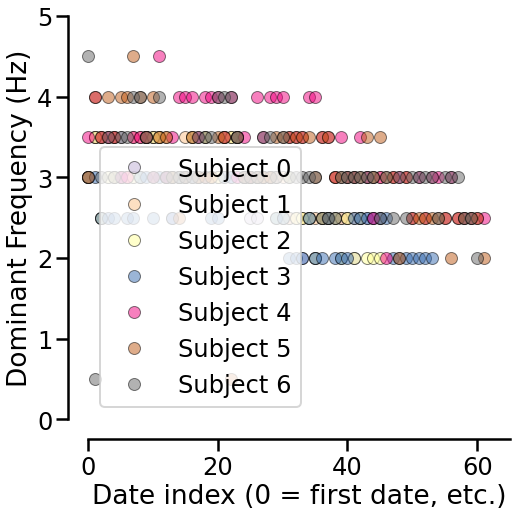

In [125]:
plt. figure(figsize=(7,7))
for subj_idx, subj_dom in enumerate(dominant_freq_list):
    print(subj_idx, subj_dom)
    # subj_dom[:,0] is the date (or date index)
    sorted_idx = np.argsort(subj_dom[:,0].astype(int))  # sort numerically by date
    #print(sorted)
    x_vals = np.arange(len(subj_dom))  # 0,1,2,...
    y_vals = subj_dom[sorted_idx, 1].astype(float)  # dominant frequency values sorted by date
    #print(type(y_vals[0]))  # dominant frequency

    plt.plot(x_vals, y_vals, 'o', label=f"Subject {subj_idx}", color = subject_colors[subj_idx+1], markeredgecolor='k', clip_on=False, alpha=0.5)

plt.xlabel("Date index (0 = first date, etc.)")
plt.ylabel("Dominant Frequency (Hz)")
#plt.title("Dominant Frequency per Session (Global)")
plt.ylim(0, 5)
plt.xlim(0,65)
#plt.grid(True)
plt.legend()
plt.tight_layout()
sns.despine(offset=20)
plt.savefig('dom_breathing_freq_across_training.svg', format ='svg', transparent=True, bbox_inches='tight')

plt.show()

0 [['20250530' '3.41796875']
 ['20250601' '3.90625']
 ['20250602' '3.41796875']
 ['20250603' '3.41796875']
 ['20250604' '3.41796875']
 ['20250605' '2.9296875']
 ['20250606' '2.9296875']
 ['20250607' '3.90625']
 ['20250608' '3.41796875']
 ['20250609' '3.41796875']
 ['20250610' '2.9296875']
 ['20250611' '4.39453125']
 ['20250612' '2.9296875']
 ['20250613' '3.41796875']
 ['20250616' '3.90625']
 ['20250617' '3.90625']
 ['20250618' '3.90625']
 ['20250619' '3.41796875']
 ['20250620' '3.90625']
 ['20250622' '4.39453125']
 ['20250623' '3.90625']
 ['20250624' '3.41796875']
 ['20250625' '4.39453125']
 ['20250626' '3.41796875']
 ['20250627' '3.90625']
 ['20250628' '2.9296875']
 ['20250630' '3.90625']
 ['20250701' '3.41796875']
 ['20250702' '3.90625']
 ['20250703' '4.39453125']
 ['20250706' '3.90625']
 ['20250707' '3.90625']
 ['20250708' '3.41796875']
 ['20250709' '3.90625']
 ['20250710' '3.90625']
 ['20250711' '3.90625']
 ['20250713' '3.41796875']
 ['20250714' '3.41796875']
 ['20250715' '2.929687

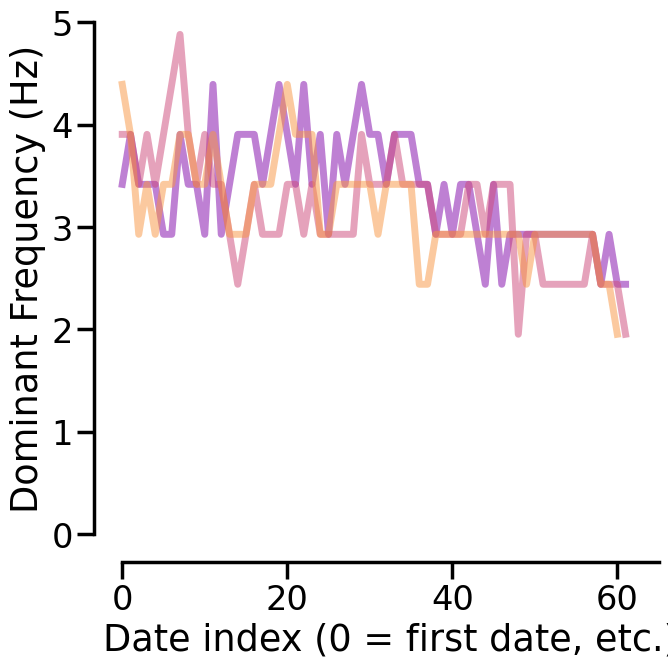

In [54]:
import numpy as np
import matplotlib.pyplot as plt
plt. figure(figsize=(7,7))
for subj_idx, subj_dom in enumerate(dominant_freq_list):
    print(subj_idx, subj_dom)
    # subj_dom[:,0] is the date (or date index)
    sorted_idx = np.argsort(subj_dom[:,0].astype(int))  # sort numerically by date
    #print(sorted)
    x_vals = np.arange(len(subj_dom))  # 0,1,2,...
    y_vals = subj_dom[sorted_idx, 1].astype(float)  # dominant frequency values sorted by date
    #print(type(y_vals[0]))  # dominant frequency

    plt.plot(x_vals, y_vals, linestyle= '-', linewidth=5, label=f"Subject {subj_idx}", color = subject_colors[subj_idx+1],  clip_on=False, alpha=0.5) #markeredgecolor='k',

plt.xlabel("Date index (0 = first date, etc.)")
plt.ylabel("Dominant Frequency (Hz)")
#plt.title("Dominant Frequency per Session (Global)")
plt.ylim(0, 5)
plt.xlim(0,65)
#plt.grid(True)
#plt.legend()
plt.tight_layout()
sns.despine(offset=20)
plt.show()

In [40]:
spec_list = []
dominant_freq_list = []
time_varying_dom_list = []

for i in range(len(all_breathing_list)):
    # --- Group and pad trials per date for this subject ---
    grouped_by_date = group_and_pad_by_date(all_breathing_list[i])

    spectrograms = []
    dominant_freq = []
    time_varying_dom = []

    # --- Compute spectrogram per date ---
    for date, all_trials in grouped_by_date.items():  
        # all_trials shape: (n_trials, max_len_for_this_date)

        Sxx_trials = []
        for trial in all_trials:
            f, t, Sxx = spectrogram(trial, fs=1000, nperseg=1000, noverlap=0)
            Sxx_trials.append(Sxx)

        # Average across trials
        Sxx_mean = np.mean(Sxx_trials, axis=0)

        # Save full spectrogram
        #spectrograms.append((date, f, t, Sxx_trials))
        spectrograms.append(Sxx_trials)

        # --- Global dominant frequency (across all time bins) ---
        mean_power = np.mean(Sxx_mean, axis=1)
        dom_freq_val = f[np.argmax(mean_power)]
        dominant_freq.append([date, dom_freq_val])

        # --- Time-varying dominant frequency (per time bin) ---
        dom_freq_time = f[np.argmax(Sxx_mean, axis=0)]
        time_varying_dom.append((date, dom_freq_time))

    # Save results per subject
    spec_list.append(spectrograms)
    dominant_freq_list.append(np.array(dominant_freq))
    time_varying_dom_list.append(time_varying_dom)

all_arrays = [
    arr
    for subj in spec_list        # outermost list
    for session in subj          # middle list
    for arr in session           # each element is already an ndarray
]

stacked = np.stack(all_arrays, axis=0)

print(stacked.shape)




(6355, 501, 10)


In [48]:
np.save('bnps_ev_spectrograms.npy', stacked)

In [52]:
mb_spectrogram = np.load('spectrograms_5s_mb_animals.npy', allow_pickle=True)

In [54]:
full_stack = np.concatenate([stacked, mb_spectrogram])

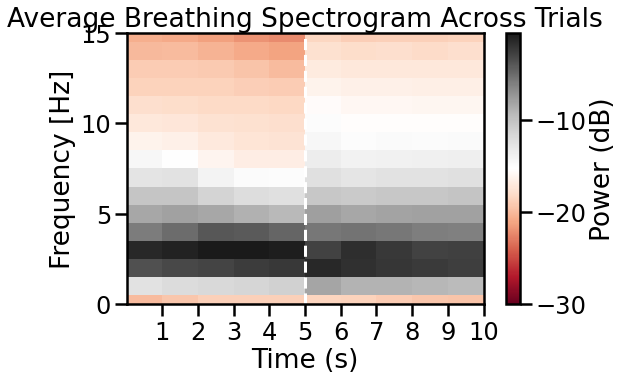

In [72]:

plt.figure(figsize=(8,5))
plt.pcolormesh(t, f, 10*np.log10(np.mean(full_stack, axis=0)), shading='nearest', cmap=sns.color_palette("RdGy", as_cmap=True), vmin=-30, rasterized=True)
plt.ylim(0, 15)
plt.colorbar(label='Power (dB)')
plt.xlabel('Time (s)')
plt.xticks(t+0.5)
plt.vlines(5,0,15,color='white',linestyle='--')
plt.ylabel('Frequency [Hz]')
plt.title('Average Breathing Spectrogram Across Trials')
#plt.vlines(6,0,15,color='white',linestyle='--')

plt.savefig('spectrogram_all_animals.svg', format='svg', transparent=True, bbox_inches='tight')

plt.show()

In [262]:
def describe_structure(obj, level=0):
    indent = "  " * level
    if isinstance(obj, list):
        print(f"{indent}List of length {len(obj)}")
        for i, item in enumerate(obj):
            print(f"{indent}  └─ Element {i}:")
            describe_structure(item, level + 2)
    else:
        print(f"{indent}{type(obj).__name__}")

print(describe_structure(spec_list))  # should be 4: subjects -> dates -> trials -> Sxx arrays

List of length 3
  └─ Element 0:
    List of length 62
      └─ Element 0:
        List of length 104
          └─ Element 0:
            ndarray
          └─ Element 1:
            ndarray
          └─ Element 2:
            ndarray
          └─ Element 3:
            ndarray
          └─ Element 4:
            ndarray
          └─ Element 5:
            ndarray
          └─ Element 6:
            ndarray
          └─ Element 7:
            ndarray
          └─ Element 8:
            ndarray
          └─ Element 9:
            ndarray
          └─ Element 10:
            ndarray
          └─ Element 11:
            ndarray
          └─ Element 12:
            ndarray
          └─ Element 13:
            ndarray
          └─ Element 14:
            ndarray
          └─ Element 15:
            ndarray
          └─ Element 16:
            ndarray
          └─ Element 17:
            ndarray
          └─ Element 18:
            ndarray
          └─ Element 19:
            ndarray
        